# 1. Import libraries

In [47]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, classification_report, confusion_matrix, roc_curve
%matplotlib notebook
import joblib

# 2. Import dataset

The Kaggle dataset contains information of the sellers (and customers) of a C2C e-commerce website. To make this dataset suitable for our analysis, the raw dataset was cleaned, and the "fraud" column is added as a target variable with two unique values (1 for fraudulent sales activity, 0 otherwise) (A sale has been termed to be fraud if the sent product mismatches the product description at the verification process before shipping.)

In [56]:
# Import raw data from kaggle
data = pd.read_csv('raw_data.csv')
data.head()

,identifierHash,type,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,...,civilityTitle,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode
0,-1097895247965112460,user,Royaume-Uni,en,147,10,77,26,174,74.0,...,mr,True,False,True,True,11,3196,106.53,8.88,gb
1,2347567364561867620,user,Monaco,en,167,8,2,19,170,99.0,...,mrs,True,False,True,True,12,3204,106.80,8.90,mc
2,6870940546848049750,user,France,fr,137,13,60,33,163,94.0,...,mrs,True,False,True,False,11,3203,106.77,8.90,fr
3,-4640272621319568052,user,Etats-Unis,en,131,10,14,122,152,92.0,...,mrs,True,False,True,False,12,3198,106.60,8.88,us
4,-5175830994878542658,user,Etats-Unis,en,167,8,0,25,125,100.0,...,mrs,False,False,False,True,22,2854,95.13,7.93,us


In [57]:
# Get variables in dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   identifierHash       98913 non-null  int64  
 1   type                 98913 non-null  object 
 2   country              98913 non-null  object 
 3   language             98913 non-null  object 
 4   socialNbFollowers    98913 non-null  int64  
 5   socialNbFollows      98913 non-null  int64  
 6   socialProductsLiked  98913 non-null  int64  
 7   productsListed       98913 non-null  int64  
 8   productsSold         98913 non-null  int64  
 9   productsPassRate     98913 non-null  float64
 10  productsWished       98913 non-null  int64  
 11  productsBought       98913 non-null  int64  
 12  gender               98913 non-null  object 
 13  civilityGenderId     98913 non-null  int64  
 14  civilityTitle        98913 non-null  object 
 15  hasAnyApp            98913 non-null 

There are 24 variables in the dataset. Not all are relevant and there are categorical data type

# 3. Feature Engineering

Feature Engineering is the process of transforming raw data into useful features that help us to understand our model better and increase its predictive power. 

In [58]:
# Drop irrelevant columns
data.drop(['identifierHash','type','country','language','civilityTitle','civilityGenderId','seniorityAsMonths','seniorityAsYears','countryCode','hasAndroidApp','hasIosApp'],axis=1,inplace=True)

In [59]:
# Add new columns for no of products passed and products failed
for i in data.index:
    case_no = data.loc[i,'productsSold']
    pass_no = round((case_no * data.loc[i,'productsPassRate']) / 100)
    fail_no = case_no - pass_no
    data.loc[i,'productsPassed'] = pass_no
    data.loc[i,'productsFailed'] = fail_no
    if case_no == 0:
        data.drop(i, axis=0,inplace=True) # Drop rows with no products sold as we cannot determine fradulence iow may be new seller
data.drop(['productsPassRate','productsSold'], axis=1,inplace=True)

In [60]:
# Encode categorical variable ('True', 'False') to numerical values
Encodedict={}
for i in ['gender','hasAnyApp','hasProfilePicture']:
    key='_{}'.format(i)
    le=LabelEncoder()
    data[key]=le.fit_transform(list(data[i]))
    Encodedict[key]=le.classes_                          
data.drop(['gender','hasAnyApp','hasProfilePicture'],axis=1,inplace=True)

In [61]:
# Determine 'Fraud' value based on productsPassed and productsFailed
indices = data.index
dfdict = {}
for j in indices:
    pp = data.loc[j,'productsPassed']
    pf = data.loc[j,'productsFailed']
    if pp != 0:
        data.loc[j,'Fraud'] = 0
        df = pd.DataFrame(data.loc[j,:]).transpose()
        ldf = pd.concat([df]*int(pp), ignore_index=True) # Replicate data pp time
    
    if pf != 0:
        data.loc[j,'Fraud'] = 1
        df2 = pd.DataFrame(data.loc[j,:]).transpose()
        ldf2 = pd.concat([df2]*int(pf), ignore_index=True)
    
    if pp!=0 and pf!=0:
        dfdict[j] = pd.concat([ldf, ldf2],ignore_index=True)
    elif pp!=0:
        dfdict[j] = ldf
    else:
        dfdict[j] = ldf2

In [62]:
whole_df = pd.concat(dfdict.values(),ignore_index=True)
whole_df.drop(['productsPassed','productsFailed'],axis=1,inplace=True)
whole_df.head()

# Save preprocessed data as new csv file
whole_df.to_csv('modified_data.csv')

# 4. Split data

In [63]:
# Load data
clndf = pd.read_csv('Dataset/modified_data.csv')
clndf.describe()

,Unnamed: 0,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsWished,productsBought,daysSinceLastLogin,seniority,_gender,_hasAnyApp,_hasProfilePicture,Fraud
count,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000
mean,6013.000000,46.023447,170.445664,579.962584,21.243868,57.850337,4.812671,74.808431,3072.820986,0.222250,0.731188,0.550262,0.226490
std,3472.040178,79.426853,1332.734395,4811.941240,38.379589,224.143179,18.866523,143.551901,166.069121,0.415776,0.443360,0.497488,0.418577
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,2852.000000,0.000000,0.000000,0.000000,0.000000
25%,3006.500000,9.000000,8.000000,1.000000,1.000000,0.000000,0.000000,11.000000,2857.000000,0.000000,0.000000,0.000000,0.000000
50%,6013.000000,21.000000,8.000000,5.000000,7.000000,0.000000,0.000000,13.000000,3196.000000,0.000000,1.000000,1.000000,0.000000
75%,9019.500000,52.000000,10.000000,46.000000,23.000000,8.000000,1.000000,43.000000,3201.000000,0.000000,1.000000,1.000000,0.000000
max,12026.000000,744.000000,13764.000000,51671.000000,244.000000,1916.000000,405.000000,709.000000,3205.000000,1.000000,1.000000,1.000000,1.000000


the ‘Fraud’ column has a mean of 0.22, way lower than 0.5, which indicates that the dataset is imbalanced and biased towards class 0. Let's fix this!

In [64]:
# Delete unnecessary column
clndf.drop(['Unnamed: 0'],axis=1,inplace=True)

In [65]:
# Specify features and target
target_data = clndf['Fraud']
feature_data = clndf.drop(labels = ['Fraud'],axis = 1,inplace = False)

In [66]:
# Perform train-test split
feature_train, feature_test, target_train, target_test = train_test_split(feature_data, target_data, test_size=0.30, random_state=101)
feature_test1, feature_test2, target_test1, target_test2 = train_test_split(feature_test, target_test, test_size=0.40, random_state=101)

# 6. Train model

## 6.1 Hyperparameter Tuning

The code below uses Scikit-Learn’s `GridSearchCV`, which is a technique for finding the optimal parameter values from a given set of parameters in a grid. As we have explicitly defined our scoring metric, grid search will identify the best model based on the optimum AUC score found during its cross-validation process.

The ‘class_weight’ parameter within the paramdict in order to tackle with the class 0 bias of the dataset.

In [67]:
# Creat instance of rf model with default parameters
model = RandomForestClassifier()

# Specify the range of parameters for model_selection module to evaluate
paramdict = {'criterion':['gini','entropy'],'min_samples_leaf':range(4,10),'class_weight':['balanced','balanced_subsample'],'max_features':['sqrt','log2'],'random_state':[101],'min_samples_split':range(2,6),'min_impurity_decrease':list(map(lambda x: x/10, range(0,5,1)))}

# Use grid search to find best hyperparameters
grid = GridSearchCV(model, paramdict, scoring=make_scorer(roc_auc_score),refit=True,verbose=0.2,cv=5,n_jobs=-1)

# Fit grid to training data
grid.fit(feature_train,target_train)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'min_samples_leaf': range(4, 10),
                         'min_samples_split': range(2, 6),
                         'random_state': [101]},
             scoring=make_scorer(roc_auc_score), verbose=0.2)

In [68]:
# Get optimal param
grid.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_features': 'sqrt',
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'random_state': 101}

All the best parameters here belong to our specified range even excluding their upper and lower limits. So, we may conclude that, this is the best model identified by grid search.

In [69]:
# Save model
joblib.dump(grid, "random_forest.joblib")

['random_forest.joblib']

# 7. Evaluate model

In [70]:
# Load model
loaded_rf = joblib.load("random_forest.joblib")

## 7.1 Visualise the results

In [71]:
rf = loaded_rf.best_estimator_

In [72]:
! pip install graphviz

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

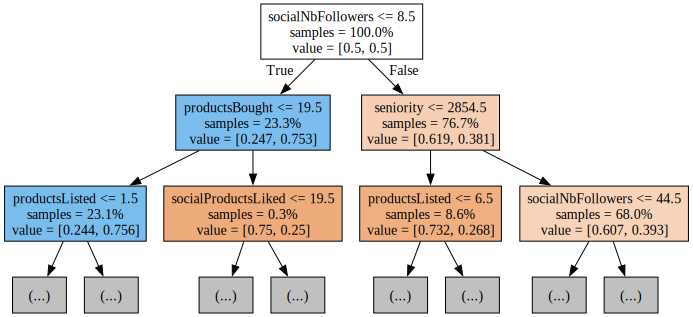

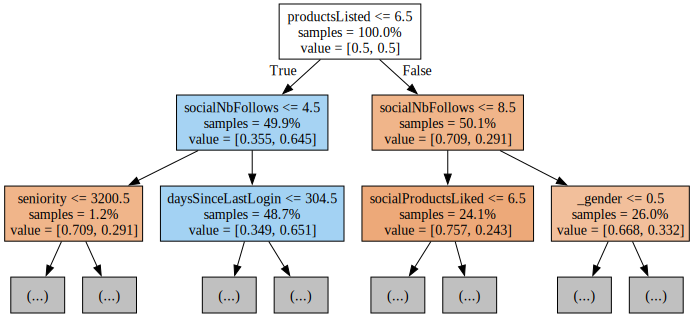

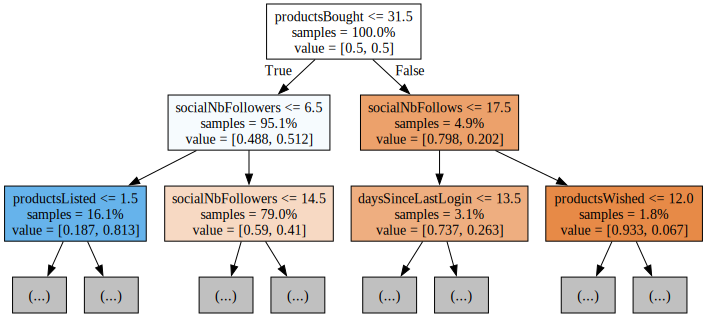

In [73]:
# Export the first three decision trees from the forest
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=feature_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Each tree image is limited to only showing the first few nodes. These trees can get very large and difficult to visualize. The colors represent the majority class of each node (box, with red indicating majority 0 (no subscription) and blue indicating majority 1 (subscription). The colors get darker the closer the node gets to being fully 0 or 1. Each node also contains the following information:

The variable name and value used for splitting
The % of total samples in each split
The % split between classes in each split

## 7.2 Evaluation metrics

In [74]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

The confusion matrix is a table that shows the number of true positives, true negatives, false positives, and false negatives for a classification model. This plots what the model predicted against what the correct prediction was. We can use this to understand the tradeoff between false positives (top right) and false negatives(bottom left)

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

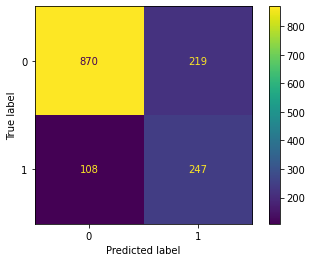

In [83]:
# Generate predictions with the best model
target_pred = rf.predict(feature_test2)

cm = confusion_matrix(target_test2, target_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

We should also evaluate the best model with accuracy, precision, and recall (note your results may differ due to randomization)

## 7.3 Visualise important features

The below code plots the importance of each feature, using the model’s internal score to find the best way to split the data within each decision tree. This tells us that the socialNbFollowers and productsListed was the biggest predictor in whether the seller is fraudulent.

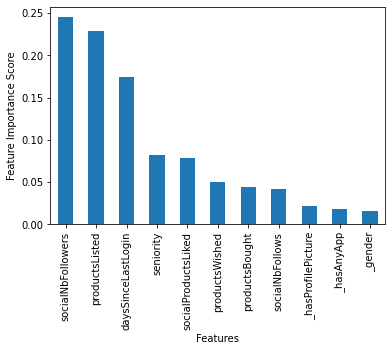

In [84]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=feature_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()
plt.ylabel('Feature Importance Score')
plt.xlabel('Features')
plt.show()

## 7.4 Classification report

In [85]:
# Print classification report for second test set
target_pred=grid.predict(feature_test)
report=classification_report(target_test,target_pred,output_dict=True)
pd.DataFrame(report)

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.899471,0.523438,0.77944,0.711454,0.810907
recall,0.801015,0.709412,0.77944,0.755213,0.779440
f1-score,0.847393,0.602398,0.77944,0.724895,0.789691
support,2759.000000,850.000000,0.77944,3609.000000,3609.000000


In [86]:
target_pred = rf.predict(feature_test2)

accuracy = accuracy_score(target_test2, target_pred)
precision = precision_score(target_test2, target_pred)
recall = recall_score(target_test2, target_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7735457063711911
Precision: 0.5300429184549357
Recall: 0.6957746478873239
